In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Tuple
from tqdm import tqdm

from src.read_data import plot_image, describe_scanpaths, collect_scanpaths
from src.similarity_2_graph import get_similarity_matrix, make_adjacency_from_similarity, find_threshold_for_size, adjacency2edgelist, make_graph_from_adjacency, make_graph_from_similarity, calc_inter, get_distance_matrix
from os.path import join
import os
from typing import Callable, Dict, List

import torch
from torch import nn
from torch import optim

from node2vec.node2vec import Node2Vec

import eyefeatures.features.scanpath_dist as eye_dist

from sklearn.model_selection import train_test_split

In [2]:
DATA_PATH = join("..", "data", "TrainingDataset", "TrainingData")
ASD_PATH  = join(DATA_PATH, "ASD")
TD_PATH   = join(DATA_PATH, "TD")

ADDITIONAL_PATH = join("..", "data", "TrainingDataset", "AdditionalData")
META_PATH = join(ADDITIONAL_PATH, "ImageAnnotations.csv")

In [3]:
info = describe_scanpaths(ASD_PATH, TD_PATH)

In [4]:
info.head()

,file_name,image_id,is_asd,min,median,max,n_participants
0,ASD_scanpath_32.txt,32,True,2,11.5,19,12
1,ASD_scanpath_206.txt,206,True,1,7.0,10,13
2,ASD_scanpath_296.txt,296,True,1,8.0,12,13
3,ASD_scanpath_240.txt,240,True,4,8.5,13,8
4,ASD_scanpath_210.txt,210,True,1,8.5,12,12


In [5]:
df = info[(info["n_participants"] == 14) & (info["min"] >= 3)]
file_names = df["file_name"].values

['face' 'people' 'people background' 'text' 'hand' 'animal' 'plant'
 'people group' 'building' 'object' 'car' 'train' 'ship' 'food' 'plane']


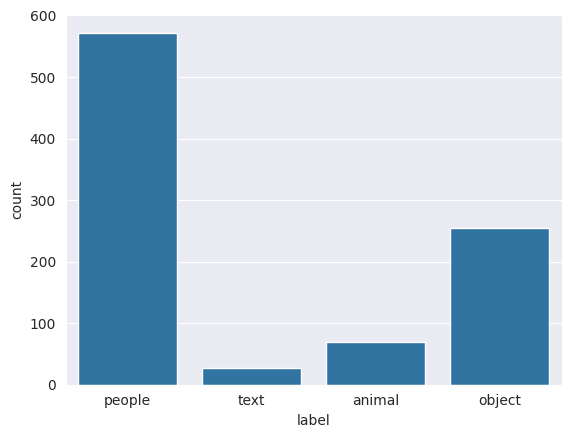

In [6]:
meta_file = pd.read_csv(META_PATH, header=None)
meta_file.rename(columns={meta_file.columns[0]: "file_name", meta_file.columns[-1]: "label"}, inplace=True)
meta_file["file_name"] = meta_file["file_name"].apply(lambda x: int(x.split("/")[-1][:-4]))
print(meta_file["label"].unique())
new_labels = {"people": "people", "face": "people", "people group": "people", "people background": "people", "hand": "people", "text": "text", "animal": "animal", }
for label in meta_file["label"].unique():
    if label not in new_labels.keys():
        new_labels[label] = "object"

meta_file["label"] = meta_file["label"].map(new_labels)

plt.tight_layout()
sns.countplot(x=meta_file["label"]);
# plt.hist(meta_file["label"]);

In [1]:
df = collect_scanpaths(file_names, ASD_PATH, TD_PATH)

meta_file = meta_file.groupby("file_name")["label"].agg(set).reset_index()
df["labels"] = df["image_id"].map(lambda x: meta_file[meta_file["file_name"] == x]["label"].values.squeeze())

df

NameError: name 'collect_scanpaths' is not defined

In [8]:
instances = np.unique(df.loc[:, ["participant_id", "image_id"]].values, axis=0)

instances_train, instances_test = train_test_split(instances, test_size=0.3, random_state=42)

In [9]:
df_train = df.merge(pd.DataFrame(instances_train, columns=['participant_id', 'image_id']), on=['participant_id', 'image_id'])
df_test = df.merge(pd.DataFrame(instances_test, columns=['participant_id', 'image_id']), on=['participant_id', 'image_id'])

In [10]:
# sim_matrix, max_dist = get_similarity_matrix(df_train, eye_dist.calc_dtw_dist, return_max_dist=True)

In [56]:
import eyefeatures.features.scanpath_complex as eye_complex
dist_matrix = np.zeros((len(instances_train) + 1, len(instances_train) + 1))
dist_matrix[:-1, :-1], object_ids = get_distance_matrix(df_train, eye_dist.calc_dtw_dist)

100%|██████████| 558/558 [01:10<00:00,  7.91it/s]


In [33]:
dist_matrix.shape, len(object_ids)

((559, 559), 558)

In [34]:
# inst = instances_test[0]
# object_ids.append((inst[0], inst[1]))

In [37]:
# test_scanpath = df_test[(df_test["participant_id"] == inst[0]) & (df_test["image_id"] == inst[1])][["x", "y"]]
# 
# new_dist_matrix = dist_matrix.copy()
# for i, inst_tr in enumerate(object_ids[:-1]):
#     train_scanpath = df_train[(df_train["participant_id"] == inst_tr[0]) & (df_train["image_id"] == inst_tr[1])][["x", "y"]]
#     dist = eye_dist.calc_dtw_dist(train_scanpath, test_scanpath)
#     
#     new_dist_matrix[-1, i] = new_dist_matrix[i, -1] = dist
# 
# new_dist_matrix /= np.max(new_dist_matrix)
# 
# n, _ = new_dist_matrix.shape
# sim_matrix = np.zeros(new_dist_matrix.shape)
# for i in range(n):
#     for j in range(i + 1, n):
#         sim_matrix[i, j] = sim_matrix[j, i] = 1 / new_dist_matrix[i, j]
# 
# sim_matrix = sim_matrix / sim_matrix.max() + np.eye(n)
# sim_matrix = pd.DataFrame(index=object_ids, columns=object_ids, data=sim_matrix)
# 
# sim_matrix

,"(1, 2)","(1, 7)","(1, 17)","(1, 20)","(1, 21)","(1, 32)","(1, 37)","(1, 40)","(1, 42)","(1, 43)",...,"(14, 195)","(14, 200)","(14, 238)","(14, 240)","(14, 251)","(14, 258)","(14, 260)","(14, 279)","(14, 297)","(13, 39)"
"(1, 2)",1.000000,0.094167,0.008036,0.014289,0.043737,0.008600,0.012602,0.011295,0.019371,0.028137,...,0.005480,0.015516,0.035234,0.072240,0.032891,0.010082,0.043558,0.013220,0.012236,0.001835
"(1, 7)",0.094167,1.000000,0.007969,0.015854,0.043430,0.013386,0.013647,0.012341,0.024859,0.028565,...,0.007836,0.012064,0.025266,0.041083,0.028688,0.013133,0.053296,0.018255,0.013266,0.001723
"(1, 17)",0.008036,0.007969,1.000000,0.002874,0.003676,0.001885,0.002492,0.007920,0.002801,0.003136,...,0.005671,0.003414,0.004243,0.006465,0.005173,0.004566,0.003137,0.002409,0.003841,0.000924
"(1, 20)",0.014289,0.015854,0.002874,1.000000,0.006765,0.005434,0.009184,0.004935,0.009069,0.007776,...,0.003591,0.006543,0.007120,0.006006,0.007629,0.004373,0.006062,0.005925,0.008733,0.003201
"(1, 21)",0.043737,0.043430,0.003676,0.006765,1.000000,0.003710,0.008077,0.008067,0.015681,0.006428,...,0.007926,0.009131,0.014041,0.008696,0.013742,0.014877,0.004817,0.004829,0.016190,0.002084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(14, 258)",0.010082,0.013133,0.004566,0.004373,0.014877,0.003511,0.001376,0.007651,0.007261,0.004559,...,0.019073,0.009709,0.012862,0.016170,0.062053,1.000000,0.008140,0.008215,0.018404,0.001859
"(14, 260)",0.043558,0.053296,0.003137,0.006062,0.004817,0.012001,0.003405,0.006504,0.006733,0.009643,...,0.005893,0.008443,0.004993,0.017338,0.025709,0.008140,1.000000,0.017860,0.012110,0.003976
"(14, 279)",0.013220,0.018255,0.002409,0.005925,0.004829,0.007126,0.002639,0.005088,0.005132,0.014239,...,0.004239,0.011010,0.004732,0.009208,0.014362,0.008215,0.017860,1.000000,0.008265,0.004103
"(14, 297)",0.012236,0.013266,0.003841,0.008733,0.016190,0.004276,0.001957,0.007028,0.013749,0.014987,...,0.006234,0.010555,0.012225,0.014928,0.036131,0.018404,0.012110,0.008265,1.000000,0.003728


In [39]:
def add_new_similarity_line(dist_matrix, object_ids, df_with_scanpath, new_scanpath):
    new_dist_matrix = dist_matrix.copy()
    for i, inst_tr in enumerate(object_ids[:-1]):
        train_scanpath = df_with_scanpath[(df_with_scanpath["participant_id"] == inst_tr[0]) & (df_with_scanpath["image_id"] == inst_tr[1])][["x", "y"]]
        dist = eye_dist.calc_dtw_dist(train_scanpath, new_scanpath)
        
        new_dist_matrix[-1, i] = new_dist_matrix[i, -1] = dist
    
    new_dist_matrix /= np.max(new_dist_matrix)
    
    n, _ = new_dist_matrix.shape
    sim_matrix = np.zeros(new_dist_matrix.shape)
    for i in range(n):
        for j in range(i + 1, n):
            sim_matrix[i, j] = sim_matrix[j, i] = 1 / new_dist_matrix[i, j]
    
    sim_matrix = sim_matrix / sim_matrix.max() + np.eye(n)
    sim_matrix = pd.DataFrame(index=object_ids, columns=object_ids, data=sim_matrix)
    
    return sim_matrix

In [40]:
sp = df_test[(df_test["participant_id"] == inst[0]) & (df_test["image_id"] == inst[1])][["x", "y"]]
sim = add_new_similarity_line(dist_matrix, object_ids, df_train, sp)
sim

,"(1, 2)","(1, 7)","(1, 17)","(1, 20)","(1, 21)","(1, 32)","(1, 37)","(1, 40)","(1, 42)","(1, 43)",...,"(14, 195)","(14, 200)","(14, 238)","(14, 240)","(14, 251)","(14, 258)","(14, 260)","(14, 279)","(14, 297)","(13, 39)"
"(1, 2)",1.000000,0.094167,0.008036,0.014289,0.043737,0.008600,0.012602,0.011295,0.019371,0.028137,...,0.005480,0.015516,0.035234,0.072240,0.032891,0.010082,0.043558,0.013220,0.012236,0.001835
"(1, 7)",0.094167,1.000000,0.007969,0.015854,0.043430,0.013386,0.013647,0.012341,0.024859,0.028565,...,0.007836,0.012064,0.025266,0.041083,0.028688,0.013133,0.053296,0.018255,0.013266,0.001723
"(1, 17)",0.008036,0.007969,1.000000,0.002874,0.003676,0.001885,0.002492,0.007920,0.002801,0.003136,...,0.005671,0.003414,0.004243,0.006465,0.005173,0.004566,0.003137,0.002409,0.003841,0.000924
"(1, 20)",0.014289,0.015854,0.002874,1.000000,0.006765,0.005434,0.009184,0.004935,0.009069,0.007776,...,0.003591,0.006543,0.007120,0.006006,0.007629,0.004373,0.006062,0.005925,0.008733,0.003201
"(1, 21)",0.043737,0.043430,0.003676,0.006765,1.000000,0.003710,0.008077,0.008067,0.015681,0.006428,...,0.007926,0.009131,0.014041,0.008696,0.013742,0.014877,0.004817,0.004829,0.016190,0.002084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(14, 258)",0.010082,0.013133,0.004566,0.004373,0.014877,0.003511,0.001376,0.007651,0.007261,0.004559,...,0.019073,0.009709,0.012862,0.016170,0.062053,1.000000,0.008140,0.008215,0.018404,0.001859
"(14, 260)",0.043558,0.053296,0.003137,0.006062,0.004817,0.012001,0.003405,0.006504,0.006733,0.009643,...,0.005893,0.008443,0.004993,0.017338,0.025709,0.008140,1.000000,0.017860,0.012110,0.003976
"(14, 279)",0.013220,0.018255,0.002409,0.005925,0.004829,0.007126,0.002639,0.005088,0.005132,0.014239,...,0.004239,0.011010,0.004732,0.009208,0.014362,0.008215,0.017860,1.000000,0.008265,0.004103
"(14, 297)",0.012236,0.013266,0.003841,0.008733,0.016190,0.004276,0.001957,0.007028,0.013749,0.014987,...,0.006234,0.010555,0.012225,0.014928,0.036131,0.018404,0.012110,0.008265,1.000000,0.003728


In [57]:
def get_embeddings(dist_matrix, object_ids, train_data, new_scanpath):
    # data = pd.concat([train_data, element_to_pred], axis=0)
    # data.reset_index(drop=True, inplace=True)
    
    # similarity_matrix = get_similarity_matrix(data, eye_dist.calc_dtw_dist)
    similarity_matrix = add_new_similarity_line(dist_matrix, object_ids, train_data, new_scanpath)
    graph = make_graph_from_similarity(similarity_matrix, 0.1)
    # print(graph.nodes)
    node2vec = Node2Vec(graph, dimensions=64, walk_length=10, num_walks=100, workers=10)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    
    return model.wv

In [78]:
from sklearn.neighbors import KNeighborsClassifier

acc = 0
gt = []
preds = []
for instance in tqdm(instances_test):
    embed = get_embeddings(dist_matrix, object_ids + [(instance[0], instance[1])], df_train, df_test[(df_test["participant_id"] == instance[0]) & (df_test["image_id"] == instance[1])][['x', 'y']])
    gt.append(df_test[(df_test["participant_id"] == instance[0]) & (df_test["image_id"] == instance[1])]['is_asd'].values[0])

    word_embeddings = {word: (embed[word], int(df_train[(df_train["participant_id"] == int(word.split(', ')[0][1:])) & (df_train["image_id"] == int(word.split(', ')[1][:-1]))]['is_asd'].values[0])) for word in embed.index_to_key if word != str(tuple(instance))}
    
    # print(word_embeddings)
    # knn_train_data = np.array(word_embeddings.values())
    # print(knn_train_data.shape)
    # knn_model = KNeighborsClassifier(10, n_jobs=4)
    # knn_model.fit(knn_train_data[::, 0, ::], knn_train_data[::, 1, ::])
    # 
    # pred = knn_model.predict(embed[str(tuple(instance))])
    # print(pred)
    knn_train_data = [x[0] for x in list(word_embeddings.values())]
    knn_train_target = [x[1] for x in list(word_embeddings.values())]
    
    knn_model = KNeighborsClassifier(10, n_jobs=4)
    knn_model.fit(np.array(knn_train_data), knn_train_target)
    
    pred = knn_model.predict(np.array(embed[str(tuple(instance))])[None, :])
    preds.append(pred)
    print(pred)
    # break
    # most_similar = embed.most_similar(str(tuple(instance)), topn=10)
    # labels = []
    # for elem in most_similar:
    #     s = [int(x) for x in elem[0][1:-1].split(', ')]
    #     labels.append(df[(df["participant_id"] == s[0]) & (df["image_id"] == s[1])]['is_asd'].values[0])
    # 
    # elems, counts = np.unique(np.array(labels), return_counts=True)
    # idx = np.argmax(counts)
    
    # preds.append(elems[idx])

  0%|          | 0/240 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  0%|          | 1/240 [00:27<1:49:11, 27.41s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  1%|          | 2/240 [00:53<1:46:24, 26.83s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  1%|▏         | 3/240 [01:17<1:40:05, 25.34s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  2%|▏         | 4/240 [01:38<1:33:28, 23.76s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  2%|▏         | 5/240 [02:00<1:30:21, 23.07s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  2%|▎         | 6/240 [02:26<1:34:18, 24.18s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  3%|▎         | 7/240 [02:51<1:34:19, 24.29s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  3%|▎         | 8/240 [03:16<1:34:54, 24.54s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  4%|▍         | 9/240 [03:40<1:34:23, 24.52s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  4%|▍         | 10/240 [04:03<1:31:07, 23.77s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  5%|▍         | 11/240 [04:25<1:28:47, 23.26s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  5%|▌         | 12/240 [04:46<1:26:15, 22.70s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  5%|▌         | 13/240 [05:20<1:38:35, 26.06s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  6%|▌         | 14/240 [05:43<1:34:54, 25.20s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  6%|▋         | 15/240 [06:05<1:30:12, 24.05s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  7%|▋         | 16/240 [06:27<1:27:59, 23.57s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  7%|▋         | 17/240 [06:57<1:34:27, 25.41s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  8%|▊         | 18/240 [07:18<1:30:02, 24.34s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  8%|▊         | 19/240 [07:39<1:25:40, 23.26s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  8%|▊         | 20/240 [08:05<1:28:19, 24.09s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  9%|▉         | 21/240 [08:32<1:31:10, 24.98s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

  9%|▉         | 22/240 [08:54<1:27:01, 23.95s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 10%|▉         | 23/240 [09:16<1:24:42, 23.42s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 10%|█         | 24/240 [09:42<1:27:14, 24.24s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 10%|█         | 25/240 [10:05<1:25:48, 23.95s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 11%|█         | 26/240 [10:28<1:23:24, 23.38s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 11%|█▏        | 27/240 [10:51<1:23:20, 23.48s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 12%|█▏        | 28/240 [11:12<1:20:17, 22.72s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 12%|█▏        | 29/240 [11:34<1:18:37, 22.36s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 12%|█▎        | 30/240 [12:00<1:22:05, 23.46s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 13%|█▎        | 31/240 [12:26<1:24:48, 24.35s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 13%|█▎        | 32/240 [12:49<1:22:33, 23.82s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 14%|█▍        | 33/240 [13:12<1:21:34, 23.65s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 14%|█▍        | 34/240 [13:33<1:18:43, 22.93s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 15%|█▍        | 35/240 [13:55<1:17:25, 22.66s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 15%|█▌        | 36/240 [14:22<1:21:39, 24.02s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 15%|█▌        | 37/240 [14:47<1:21:45, 24.17s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 16%|█▌        | 38/240 [15:10<1:20:31, 23.92s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 16%|█▋        | 39/240 [15:33<1:18:54, 23.55s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 17%|█▋        | 40/240 [16:00<1:21:58, 24.59s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 17%|█▋        | 41/240 [16:22<1:19:10, 23.87s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 18%|█▊        | 42/240 [16:44<1:16:59, 23.33s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 18%|█▊        | 43/240 [17:10<1:19:05, 24.09s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 18%|█▊        | 44/240 [17:33<1:17:36, 23.76s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 19%|█▉        | 45/240 [17:56<1:16:40, 23.59s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 19%|█▉        | 46/240 [18:19<1:15:41, 23.41s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 20%|█▉        | 47/240 [18:43<1:15:58, 23.62s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 20%|██        | 48/240 [19:04<1:13:08, 22.86s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 20%|██        | 49/240 [19:29<1:14:19, 23.35s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 21%|██        | 50/240 [19:51<1:12:36, 22.93s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 21%|██▏       | 51/240 [20:12<1:10:45, 22.47s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 22%|██▏       | 52/240 [20:33<1:08:38, 21.91s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 22%|██▏       | 53/240 [20:53<1:06:41, 21.40s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 22%|██▎       | 54/240 [21:14<1:06:06, 21.33s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 23%|██▎       | 55/240 [21:34<1:04:36, 20.95s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 23%|██▎       | 56/240 [21:55<1:03:41, 20.77s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 24%|██▍       | 57/240 [22:14<1:02:18, 20.43s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 24%|██▍       | 58/240 [22:34<1:01:02, 20.12s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 25%|██▍       | 59/240 [22:52<59:26, 19.71s/it]  

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 25%|██▌       | 60/240 [23:08<55:20, 18.45s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 25%|██▌       | 61/240 [23:28<56:02, 18.78s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 26%|██▌       | 62/240 [23:47<56:01, 18.88s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 26%|██▋       | 63/240 [24:07<56:39, 19.20s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 27%|██▋       | 64/240 [24:25<55:50, 19.03s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 27%|██▋       | 65/240 [24:45<56:04, 19.23s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 28%|██▊       | 66/240 [25:06<56:56, 19.64s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 28%|██▊       | 67/240 [25:25<56:09, 19.48s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 28%|██▊       | 68/240 [25:44<55:49, 19.47s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 29%|██▉       | 69/240 [26:02<53:52, 18.90s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 29%|██▉       | 70/240 [26:21<53:52, 19.02s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 30%|██▉       | 71/240 [26:40<53:47, 19.10s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 30%|███       | 72/240 [26:58<52:19, 18.69s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 30%|███       | 73/240 [27:17<52:26, 18.84s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 31%|███       | 74/240 [27:36<52:30, 18.98s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 31%|███▏      | 75/240 [27:56<52:58, 19.26s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 32%|███▏      | 76/240 [28:16<52:37, 19.25s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 32%|███▏      | 77/240 [28:36<53:08, 19.56s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 32%|███▎      | 78/240 [28:56<53:01, 19.64s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 33%|███▎      | 79/240 [29:15<52:07, 19.43s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 33%|███▎      | 80/240 [29:34<52:06, 19.54s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 34%|███▍      | 81/240 [29:54<51:40, 19.50s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 34%|███▍      | 82/240 [30:12<50:04, 19.02s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 35%|███▍      | 83/240 [30:31<49:44, 19.01s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 35%|███▌      | 84/240 [30:50<49:38, 19.09s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 35%|███▌      | 85/240 [31:09<48:54, 18.93s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 36%|███▌      | 86/240 [31:28<49:08, 19.15s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 36%|███▋      | 87/240 [31:48<49:16, 19.33s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 37%|███▋      | 88/240 [32:08<49:36, 19.58s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 37%|███▋      | 89/240 [32:28<49:11, 19.55s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 38%|███▊      | 90/240 [32:47<48:22, 19.35s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 38%|███▊      | 91/240 [33:06<48:03, 19.35s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 38%|███▊      | 92/240 [33:26<48:07, 19.51s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 39%|███▉      | 93/240 [33:46<48:18, 19.72s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 39%|███▉      | 94/240 [34:05<47:13, 19.41s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 40%|███▉      | 95/240 [34:24<46:40, 19.32s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 40%|████      | 96/240 [34:42<45:21, 18.90s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 40%|████      | 97/240 [35:00<44:51, 18.83s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 41%|████      | 98/240 [35:19<44:12, 18.68s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 41%|████▏     | 99/240 [35:38<44:14, 18.82s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 42%|████▏     | 100/240 [35:57<44:15, 18.97s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 42%|████▏     | 101/240 [36:17<44:40, 19.28s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 42%|████▎     | 102/240 [36:37<44:35, 19.39s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 43%|████▎     | 103/240 [36:57<44:35, 19.53s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 43%|████▎     | 104/240 [37:16<44:20, 19.57s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 44%|████▍     | 105/240 [37:36<43:57, 19.54s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 44%|████▍     | 106/240 [37:55<43:08, 19.32s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 45%|████▍     | 107/240 [38:15<43:33, 19.65s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 45%|████▌     | 108/240 [38:34<42:36, 19.36s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 45%|████▌     | 109/240 [38:54<42:55, 19.66s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 46%|████▌     | 110/240 [39:16<43:54, 20.27s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 46%|████▋     | 111/240 [39:38<44:37, 20.75s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 47%|████▋     | 112/240 [39:58<44:16, 20.75s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 47%|████▋     | 113/240 [40:20<44:31, 21.04s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 48%|████▊     | 114/240 [40:41<44:00, 20.96s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 48%|████▊     | 115/240 [41:03<44:21, 21.29s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 48%|████▊     | 116/240 [41:23<43:29, 21.04s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 49%|████▉     | 117/240 [41:41<40:58, 19.98s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 49%|████▉     | 118/240 [42:00<40:00, 19.68s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 50%|████▉     | 119/240 [42:20<40:14, 19.96s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 50%|█████     | 120/240 [42:41<40:09, 20.08s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 50%|█████     | 121/240 [43:02<40:31, 20.43s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 51%|█████     | 122/240 [43:22<40:03, 20.37s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 51%|█████▏    | 123/240 [43:42<39:34, 20.29s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 52%|█████▏    | 124/240 [44:06<40:50, 21.13s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 52%|█████▏    | 125/240 [44:27<40:40, 21.22s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 52%|█████▎    | 126/240 [44:47<39:32, 20.81s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 53%|█████▎    | 127/240 [45:08<39:20, 20.89s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 53%|█████▎    | 128/240 [45:31<40:13, 21.55s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 54%|█████▍    | 129/240 [45:51<39:13, 21.20s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 54%|█████▍    | 130/240 [46:11<38:03, 20.76s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 55%|█████▍    | 131/240 [46:29<36:22, 20.03s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 55%|█████▌    | 132/240 [46:49<35:39, 19.81s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 55%|█████▌    | 133/240 [47:08<35:05, 19.68s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 56%|█████▌    | 134/240 [47:28<34:50, 19.72s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 56%|█████▋    | 135/240 [47:48<34:51, 19.92s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 57%|█████▋    | 136/240 [48:07<33:52, 19.54s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 57%|█████▋    | 137/240 [48:26<33:33, 19.55s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 57%|█████▊    | 138/240 [48:47<33:40, 19.81s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 58%|█████▊    | 139/240 [49:05<32:35, 19.36s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 58%|█████▊    | 140/240 [49:26<33:10, 19.90s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 59%|█████▉    | 141/240 [49:47<32:56, 19.97s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 59%|█████▉    | 142/240 [50:08<33:20, 20.41s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 60%|█████▉    | 143/240 [50:27<32:28, 20.09s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 60%|██████    | 144/240 [50:49<33:08, 20.71s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 60%|██████    | 145/240 [51:10<32:28, 20.51s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 61%|██████    | 146/240 [51:31<32:45, 20.91s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 61%|██████▏   | 147/240 [51:52<32:27, 20.95s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 62%|██████▏   | 148/240 [52:14<32:25, 21.15s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 62%|██████▏   | 149/240 [52:34<31:45, 20.94s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 62%|██████▎   | 150/240 [52:55<31:17, 20.86s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 63%|██████▎   | 151/240 [53:15<30:26, 20.52s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 63%|██████▎   | 152/240 [53:34<29:39, 20.22s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 64%|██████▍   | 153/240 [53:54<29:11, 20.14s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 64%|██████▍   | 154/240 [54:14<28:49, 20.11s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 65%|██████▍   | 155/240 [54:35<28:36, 20.19s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 65%|██████▌   | 156/240 [54:54<28:05, 20.06s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 65%|██████▌   | 157/240 [55:13<27:17, 19.73s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 66%|██████▌   | 158/240 [55:33<26:59, 19.75s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 66%|██████▋   | 159/240 [55:52<26:07, 19.35s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 67%|██████▋   | 160/240 [56:11<25:55, 19.45s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 67%|██████▋   | 161/240 [56:31<25:44, 19.55s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 68%|██████▊   | 162/240 [56:52<26:02, 20.03s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 68%|██████▊   | 163/240 [57:12<25:27, 19.84s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 68%|██████▊   | 164/240 [57:33<25:34, 20.19s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 69%|██████▉   | 165/240 [57:53<25:25, 20.35s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 69%|██████▉   | 166/240 [58:14<25:09, 20.41s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 70%|██████▉   | 167/240 [58:34<24:52, 20.44s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 70%|███████   | 168/240 [58:55<24:41, 20.57s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 70%|███████   | 169/240 [59:17<24:45, 20.92s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 71%|███████   | 170/240 [59:38<24:22, 20.89s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 71%|███████▏  | 171/240 [59:59<24:00, 20.88s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 72%|███████▏  | 172/240 [1:00:18<23:00, 20.30s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 72%|███████▏  | 173/240 [1:00:40<23:16, 20.85s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 72%|███████▎  | 174/240 [1:01:01<23:06, 21.01s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 73%|███████▎  | 175/240 [1:01:22<22:50, 21.09s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 73%|███████▎  | 176/240 [1:01:44<22:39, 21.25s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 74%|███████▍  | 177/240 [1:02:05<22:20, 21.27s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 74%|███████▍  | 178/240 [1:02:27<21:59, 21.29s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 75%|███████▍  | 179/240 [1:02:47<21:26, 21.09s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 75%|███████▌  | 180/240 [1:03:08<21:02, 21.03s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 75%|███████▌  | 181/240 [1:03:31<21:09, 21.51s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 76%|███████▌  | 182/240 [1:03:52<20:33, 21.27s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 76%|███████▋  | 183/240 [1:04:12<19:49, 20.87s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 77%|███████▋  | 184/240 [1:04:33<19:39, 21.06s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 77%|███████▋  | 185/240 [1:04:54<19:23, 21.15s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 78%|███████▊  | 186/240 [1:05:17<19:28, 21.64s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 78%|███████▊  | 187/240 [1:05:37<18:31, 20.97s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 78%|███████▊  | 188/240 [1:05:58<18:20, 21.16s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 79%|███████▉  | 189/240 [1:06:18<17:34, 20.67s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 79%|███████▉  | 190/240 [1:06:37<16:45, 20.12s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 80%|███████▉  | 191/240 [1:06:55<16:06, 19.72s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 80%|████████  | 192/240 [1:07:20<16:58, 21.21s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 80%|████████  | 193/240 [1:07:42<16:45, 21.39s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 81%|████████  | 194/240 [1:08:06<17:02, 22.24s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 81%|████████▏ | 195/240 [1:08:25<16:02, 21.38s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 82%|████████▏ | 196/240 [1:08:44<15:08, 20.65s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 82%|████████▏ | 197/240 [1:09:04<14:34, 20.34s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 82%|████████▎ | 198/240 [1:09:23<14:02, 20.07s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 83%|████████▎ | 199/240 [1:09:43<13:38, 19.97s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 83%|████████▎ | 200/240 [1:10:03<13:15, 19.90s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 84%|████████▍ | 201/240 [1:10:23<12:52, 19.81s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 84%|████████▍ | 202/240 [1:10:43<12:37, 19.93s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 85%|████████▍ | 203/240 [1:11:03<12:22, 20.06s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 85%|████████▌ | 204/240 [1:11:23<12:01, 20.03s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 85%|████████▌ | 205/240 [1:11:42<11:33, 19.82s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 86%|████████▌ | 206/240 [1:12:02<11:10, 19.71s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 86%|████████▋ | 207/240 [1:12:22<10:50, 19.72s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 87%|████████▋ | 208/240 [1:12:42<10:36, 19.88s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 87%|████████▋ | 209/240 [1:13:01<10:09, 19.65s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 88%|████████▊ | 210/240 [1:13:20<09:44, 19.47s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 88%|████████▊ | 211/240 [1:13:39<09:22, 19.40s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 88%|████████▊ | 212/240 [1:13:58<09:01, 19.35s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 89%|████████▉ | 213/240 [1:14:18<08:44, 19.43s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 89%|████████▉ | 214/240 [1:14:38<08:31, 19.68s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 90%|████████▉ | 215/240 [1:14:59<08:16, 19.88s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 90%|█████████ | 216/240 [1:15:23<08:26, 21.10s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 90%|█████████ | 217/240 [1:15:45<08:15, 21.56s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 91%|█████████ | 218/240 [1:16:07<07:53, 21.54s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 91%|█████████▏| 219/240 [1:16:29<07:36, 21.72s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 92%|█████████▏| 220/240 [1:16:52<07:23, 22.15s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 92%|█████████▏| 221/240 [1:17:16<07:09, 22.62s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 92%|█████████▎| 222/240 [1:17:37<06:40, 22.24s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 93%|█████████▎| 223/240 [1:17:59<06:14, 22.02s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 93%|█████████▎| 224/240 [1:18:22<06:00, 22.51s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 94%|█████████▍| 225/240 [1:18:45<05:38, 22.58s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 94%|█████████▍| 226/240 [1:19:09<05:20, 22.90s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 95%|█████████▍| 227/240 [1:19:34<05:08, 23.73s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 95%|█████████▌| 228/240 [1:20:02<04:57, 24.77s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 95%|█████████▌| 229/240 [1:20:26<04:31, 24.68s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 96%|█████████▌| 230/240 [1:20:46<03:53, 23.31s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 96%|█████████▋| 231/240 [1:21:06<03:19, 22.18s/it]

[1]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 97%|█████████▋| 232/240 [1:21:26<02:53, 21.70s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 97%|█████████▋| 233/240 [1:21:47<02:28, 21.28s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 98%|█████████▊| 234/240 [1:22:08<02:07, 21.27s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 98%|█████████▊| 235/240 [1:22:28<01:45, 21.07s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 98%|█████████▊| 236/240 [1:22:48<01:22, 20.57s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 99%|█████████▉| 237/240 [1:23:09<01:01, 20.60s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

 99%|█████████▉| 238/240 [1:23:27<00:40, 20.05s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

100%|█████████▉| 239/240 [1:23:46<00:19, 19.56s/it]

[0]


Computing transition probabilities:   0%|          | 0/559 [00:00<?, ?it/s]

100%|██████████| 240/240 [1:24:05<00:00, 21.02s/it]

[0]


In [81]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score

print(f"Balanced accuracy: {balanced_accuracy_score(gt, preds)}")
print(f"F1-score: {f1_score(gt, preds)}")
print(f"Precision: {precision_score(gt, preds)}")
print(f"Recall: {recall_score(gt, preds)}")

Balanced accuracy: 0.4653919886994249
F1-score: 0.05333333333333334
Precision: 0.09090909090909091
Recall: 0.03773584905660377
